# Tweets sentiment

In [158]:
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
import string
import pickle
from wordcloud import WordCloud
from PIL import Image
import os
import pandas as pd
import numpy as np
import requests
from tqdm import tqdm_notebook as tqdm
import math
import imageio

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('dark_background')
plt.style.use('seaborn-deep')

from typing import List

data_path = 'data'

Retreive the airport data from https://openflights.org/data.html.

In [2]:
airports_filename = 'airports.csv'
routes_filename = 'routes.csv'

In [3]:
airports = pd.read_csv(os.path.join(data_path, 'airports.csv'))
airports.set_index('Airport Id', inplace=True)

In [4]:
airports

,Name,City,Country,IATA,ICAO,Latitude,Longitude,Altitude,Timezone,DST,Tz database timezone,Type,Source
Airport Id,,,,,,,,,,,,,
1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports
6,Wewak International Airport,Wewak,Papua New Guinea,WWK,AYWK,-3.583830,143.669006,19,10,U,Pacific/Port_Moresby,airport,OurAirports
7,Narsarsuaq Airport,Narssarssuaq,Greenland,UAK,BGBW,61.160500,-45.425999,112,-3,E,America/Godthab,airport,OurAirports
8,Godthaab / Nuuk Airport,Godthaab,Greenland,GOH,BGGH,64.190903,-51.678101,283,-3,E,America/Godthab,airport,OurAirports
9,Kangerlussuaq Airport,Sondrestrom,Greenland,SFJ,BGSF,67.012222,-50.711603,165,-3,E,America/Godthab,airport,OurAirports


## TF-IDF analysis of Twitter

The tweets have been retreived from twitter's API. The data we have collected can be found [here](https://1drv.ms/u/s!AoyV20xD2_Tx0vIuF0HGgFg-5CyaIw).
Every file coresponds to the id of an airport, and contain up to 100 of the latest tweets from the given airport (the dataset was generated on 2018-11-08).
As tweets can be multiline, each tweet is seperated by ';;;' in the files.

In [5]:
tweets = {
    row['Name']: ''.join(open(
        os.path.join(data_path, 'tweets', str(index)), 'r', encoding='utf-8'
    ).readlines())
    for index, row in airports.iterrows()
}

Each tweet is tokenized and cleaned to remove stopworld, punctuation, and blacklisted words, such as keywords used by twitter.

In [6]:
blacklisted_tokens = [
    'rt',
    'amp'
]
def tokenize(text: str, names: set = []) -> List[str]:
    sw = stopwords.words('english')
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens
                  if token not in names
                  and token not in sw
                  and not token.isdigit()
                  and token not in blacklisted_tokens
         ]
    return tokens

In [7]:
%%capture cap --no-stderr
tokens = { airport: tokenize(document) for airport, document in tqdm(tweets.items()) }

In [8]:
def calculate_n_ts(tokens: list, documents: list) -> set:
    ''' Calculate the n_ts for a list of tokens given a list of documents
    '''
    return {
        word: sum(1 for document in documents if word in document)
           for word in set(tokens)
    }

As calculating how many documents each of the words occure in takes some time, we have cheated a little and saved the result. To optimize the calculations, we have transformed each of the documents into sets.

In [9]:
# tokens_set = { airport: set(document) for airport, document in tokens.items() }
# n_ts = { 
#     airport: calculate_n_ts(ts, tokens_set.values()) 
#     for airport, ts in tqdm(tokens.items())
# }
# with open(os.path.join(data_path, 'n_ts.data'), 'wb') as f:
#     pickle.dumb(f)

In [10]:
with open(os.path.join(data_path, 'n_ts.data'), 'rb') as f:
    n_ts = pickle.load(f)

Calculating the IDF can now be done using the following function.

In [11]:
def calculateIDF(nts: set, N: int, base=2) -> set:
    return { word: math.log(N / n_t, base)
        for word, n_t in nts.items()
    }

In [12]:
N = len(list(airports['Name']))
IDF = {
    airport: calculateIDF(n_ts[airport], N)
    for airport in tqdm(list(airports['Name']))
}

Calculate the TF_IDF

In [13]:
def calculateTF_IDF(tfs: set, IDFs: set) -> set:
    return {
        word: tf * IDFs[word]
        for word, tf in tfs.items()
    }

In [14]:
freq = { airport: FreqDist(ts) for airport, ts in tokens.items() }

In [15]:
TF_IDF = {
    airport: calculateTF_IDF(freq[airport], IDF[airport])
    for airport in tokens.keys()
}

The most used words in all of the documents:

In [16]:
all_tokens = [t for ts in tokens.values() for t in ts]

In [17]:
freqency_total = FreqDist(all_tokens)

## Word clouds

In [162]:
def drawWordCloud(text: str, title: str, mask: str = None):
    if mask:
        mask = np.array(Image.open(os.path.join('masks', mask)))
        
    wordcloud = WordCloud(
        collocations=False,
        mask=mask,
#         background_color='white',
        contour_width=3, 
        contour_color='steelblue'
        ).generate(text)
    fig, ax = plt.subplots(figsize=(16, 8))
#     ax.set_title(title)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    imageio.imwrite(f'output/{title}.png', np.array(wordcloud))
    plt.show()

In [164]:
combined_all_tokens = ' '.join(all_tokens)

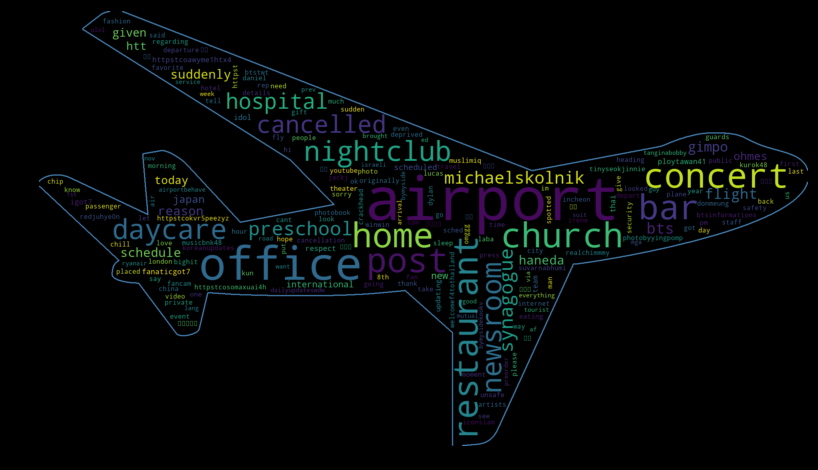

In [165]:
drawWordCloud(combined_all_tokens, 'All tokens', 'Airplane_silhouette.png')

## Sentiment

To calculate the sentiment of each of the airports, we are using the data set created in [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752).
This data set contains over 10,000 individual words and their happiness score, which is generated by having many unique people rate each of the words and calculating a aggregated score based on this.

In [20]:
happiness = pd.read_csv(os.path.join(data_path, 'sentiment.csv'), delimiter='\t')

We will be using the average happiness score for each of the words to calculate the sentiment for each of the airports.

In [21]:
h_avg = { happiness['word'].iloc[i]: happiness['happiness_average'].iloc[i] 
         for i in range(len(happiness.word)) 
    }

In [22]:
def calculate_sentiment(tokens: list, h_avg: dict) -> int:
    tokens = [word for word in tokens if word in h_avg]
    if len(tokens) == 0: 
        return 0
    frequency = FreqDist(tokens)
    return sum(h_avg[word] * frequency[word] for word in tokens) / len(tokens)

In [23]:
tweets_list = { airport: tws.split(';;;')
          for airport, tws in tweets.items()
     }

In [24]:
tweets_tokenized = { 
    airport: [tokenize(tweet) for tweet in ts]
    for airport, ts in tweets_list.items()
}

In [25]:
sentiment = {
    airport: [calculate_sentiment(tweet, h_avg) for tweet in ts]
    for airport, ts in tweets_tokenized.items()
}

In [26]:
tweets_all = [tweet for ts in tweets.values() for tweet in ts]

In [27]:
sentiment_all = [score for ss in sentiment.values() for score in ss]

Plot the distribution of the sentiment in all of the tweets.

In [149]:
def plotDistribution(data: list, title: str):
    sorted_data = [x for x in sorted(data) if x < 10 and x != 0]
    fig, ax = plt.subplots(1, figsize=(16,8))
    ax.hist(sorted_data, bins=30)
    ax.set_title(title)
    ax.set_xlabel('Happiness score')
    ax.set_ylabel('Frequency')
    fig.show()

c:\python37\lib\site-packages\matplotlib\figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


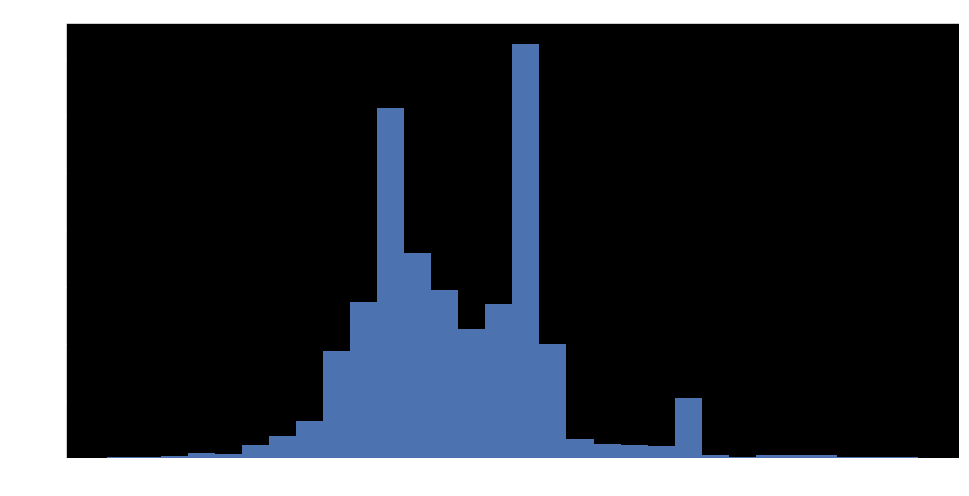

In [29]:
plotDistribution(sentiment_all, 'Overall sentiment of tweets')

In [103]:
mean = np.mean(sentiment_all)
std = np.std(sentiment_all)
print('Sentiment mean and standard deviation of all the tweets. Mean: {0:f} sigma: {1:f}'
      .format(mean, std))

Sentiment mean and standard deviation of all the tweets. Mean: 6.274149 sigma: 1.280805


Analysis tweets based on sentiment

In [31]:
negative_tweets = {
    airport: [t for i, t in enumerate(ts) if sentiment[airport][i] <= mean - 2*std]
    for airport, ts in tweets_tokenized.items()
}

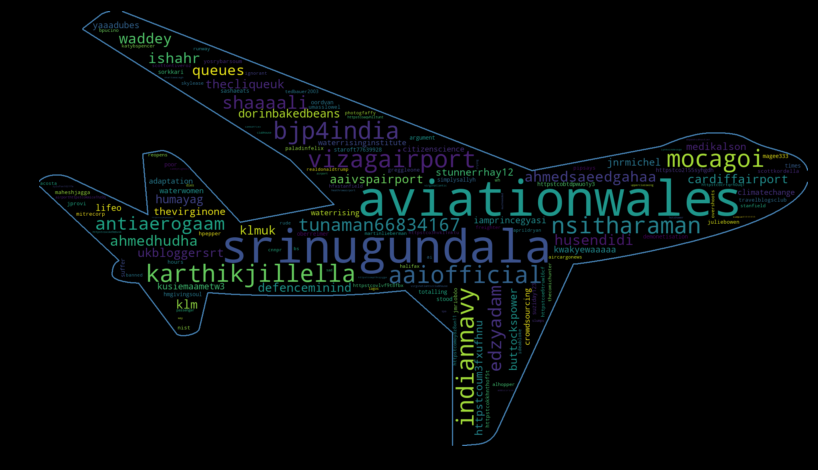

In [168]:
drawWordCloud(' '.join([' '.join(t) for ts in negative_tweets.values() for t in ts]), 
      'Negative tweets', 'Airplane_silhouette.png')

When looking at the words most used in the negative tweets, we see that they are a lot of account names are used, such official airport accounts.
The word *queue* can also be found in here, which is to be expected.

Looking at words in the positive tweets

In [100]:
positive_tweets = {
    airport: [t for i, t in enumerate(ts) if sentiment[airport][i] <= mean + 2*std]
    for airport, ts in tweets_tokenized.items()
}

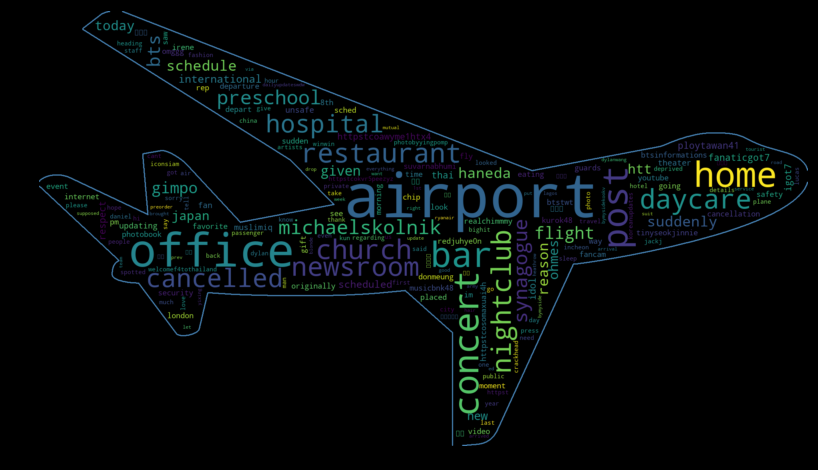

In [169]:
drawWordCloud(' '.join([' '.join(t) for ts in positive_tweets.values() for t in ts]), 
      'Positive tweets', 'Airplane_silhouette.png')

For the positive tweets, we see words such as *office*, which would point to many people are enjoying working from the airport.
Words like *bar*, *resturant*, and *nightclub* are also found, poniting to that most people enjoy being at these places.

## The least and most liked airports in the world

In [34]:
sentiment_avg = {
    airport: np.mean(values)
    for airport, values in sentiment.items()
}

In [37]:
sorted_sentiment = sorted(sentiment_avg.items(), key=lambda x: x[1])

In [95]:
def showAirportScore(airport: str):
    print(f'{airport}'.ljust(50), f'{sentiment_avg[airport]}')

First we can find the mean and standard deviation of the sentiment of the airports.

In [107]:
print('Mean and standard deviation sentiment of the airports: mean: {0:f}, sigma: {1:f}'
     .format(np.mean(list(sentiment_avg.values())), np.std(list(sentiment_avg.values()))))

Mean and standard deviation sentiment of the airports: mean: 6.274150, sigma: 0.200264


Now we can find the top five least and most liked airports in the world.

In [96]:
print('The least liked airports in the world')
for airport, _ in sorted_sentiment[:5]:
    showAirportScore(airport)

The least liked airports in the world
Dzaoudzi Pamandzi International Airport            5.605165685425686
Ouani Airport                                      5.605412113997115
Prince Said Ibrahim International Airport          5.617421637806638
Mohéli Bandar Es Eslam Airport                     5.617421637806638
Southdowns Airport                                 5.620871637806637


In [97]:
print('The most liked airports in the world')
for airport, _ in sorted_sentiment[::-1][:5]:
    showAirportScore(airport)

The most liked airports in the world
Pasni Airport                                      6.844752969252969
Doha International Airport                         6.842851937506938
Palmyra Airport                                    6.842851937506938
Bassel Al-Assad International Airport              6.832851937506938
Deir ez-Zor Airport                                6.832851937506938


In [98]:
busiest_airports = [
    'Hartsfield Jackson Atlanta International Airport',
    'Beijing Capital International Airport',
    'Dubai International Airport',
    'Los Angeles International Airport',
    'Tokyo Haneda International Airport',
    "Chicago O'Hare International Airport",
    'London Heathrow Airport',
    'Chek Lap Kok International Airport', # Hong Kong
    'Shanghai Pudong International Airport',
    'Indira Gandhi International Airport'
]

In [99]:
for airport in busiest_airports:
    showAirportScore(airport)

Hartsfield Jackson Atlanta International Airport   6.260418863913864
Beijing Capital International Airport              6.202427236652238
Dubai International Airport                        6.779575407370407
Los Angeles International Airport                  6.273325007215006
Tokyo Haneda International Airport                 5.934192453102453
Chicago O'Hare International Airport               6.210734430014429
London Heathrow Airport                            5.777641921134421
Chek Lap Kok International Airport                 6.18718961038961
Shanghai Pudong International Airport              6.191489660894661
Indira Gandhi International Airport                6.1794577994227975


In the output above, it can be seen that most of the busiest airports in the world is close to the average of all of the airports in the world, however all of them is slightly below.
London Heathrow Airport and Tokyo Haneda International Airport are quite low on the list, while Dubai International Airport is most more liked than all of the other busy airports.

## Exporting results

In [108]:
import csv

In [126]:
with open('./output/airport_sentiment.csv', 'w', encoding='utf-8', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter='\t')
    writer.writerow(('Airport', 'Sentiment'))
    for row in sorted_sentiment:
        writer.writerow(row)

In [147]:
with open('./output/sentiment_all.txt', 'w', encoding='utf-8') as f:
    for value in sorted(sentiment_all):
        if value < 10 and value != 0:
            f.write(str(value) + '\n')